In [25]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import chisquare, norm

import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import rc
rc('font', size=20)

# Generate data

In [31]:
N = int(1e7)
mu_true, sig_true = 0, 1
mu_gen, sig_gen = 0.5, 1
smearing = 0.5
n_bins = 15
epsilon = 1e-10

streams = ['truth', 'data', 'gen', 'sim']


# Generate data
truth = np.random.normal(mu_true, sig_true, N)
data = np.random.normal(truth, smearing)
gen = np.random.normal(mu_gen, sig_gen, N)
sim = np.random.normal(gen, smearing)

# Bin data

In [33]:
bins = [truth.min()]
i = 0
while bins[-1] < truth.max() and i < len(bins):
    for binhigh in np.linspace(bins[i] + 0.1, truth.max(), 20):
        in_bin = (truth > bins[i]) & (truth < binhigh)
        in_reco_bin = (data > bins[i]) & (data < binhigh)
        if np.sum(in_bin) > 0:
            purity = np.sum(in_bin & in_reco_bin) / np.sum(in_bin)
            if purity > (0.6):
                print(f"{binhigh = }, {purity = }")
                i += 1
                bins.append(binhigh)
                break
    else:
        break
bins = np.array(bins)
print(f"{len(bins) = }")
n_bins = len(bins)

def digitize_data(data):
    digitized = np.digitize(data, bins)  # Digitize the data
    clipped = np.clip(digitized, 1, n_bins) - 1  # Clip and adjust indices
    return clipped

for stream in streams:
    globals()[stream + '_hist'], _ = np.histogram(globals()[stream], bins)
    globals()[stream + '_digitized'] = digitize_data(globals()[stream])

binhigh = -3.9543608601904667, purity = 0.6482939632545932
binhigh = -2.856425763031616, purity = 0.6178158216536545
binhigh = -1.4328812905289479, purity = 0.6990123794968736
binhigh = -0.23410699789512202, purity = 0.6712994957252835
binhigh = 0.7753871432702047, purity = 0.6155482745415088
binhigh = 1.875520915806712, purity = 0.6389729809944775
binhigh = 2.9361792439677394, purity = 0.6164854832756471
binhigh = 3.990332045649641, purity = 0.6063084112149533
binhigh = 4.979416029273784, purity = 0.6099071207430341
len(bins) = 10


# Response matrix

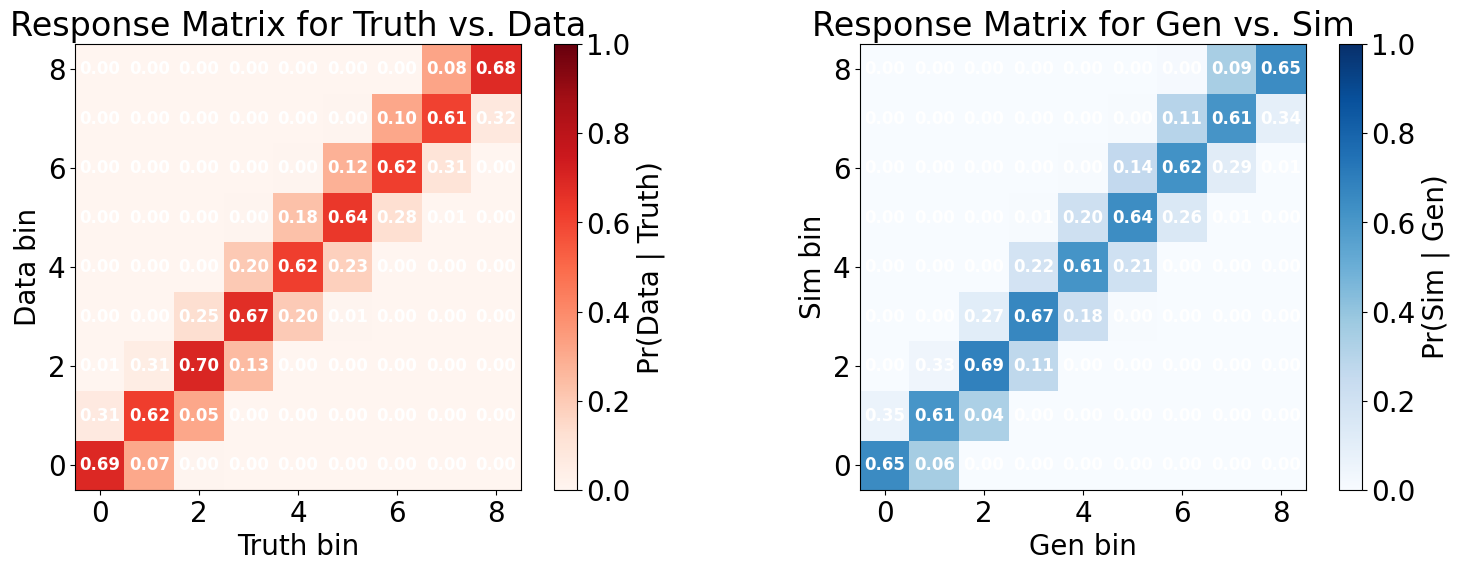

In [34]:
H, _, _ = np.histogram2d(truth_digitized, data_digitized, bins=[range(n_bins), range(n_bins)])
H_alt, _, _ = np.histogram2d(gen_digitized, sim_digitized, bins=[range(n_bins), range(n_bins)])

# Normalize the histogram row-wise
H_normalized = H / (H.sum(axis=1, keepdims=True) + epsilon)
H_normalized_alt = H_alt/(H_alt.sum(axis=1, keepdims=True) + epsilon)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))  # Two plots in one row

# First response matrix
im = axs[0].imshow(H_normalized, origin='lower', cmap="Reds", vmin=0, vmax=1)
for i in range(n_bins-1):
    for j in range(n_bins-1):
        text = axs[0].text(j, i, f"{H_normalized.T[i, j]:0.2f}",
                           ha="center", va="center", color="w", fontweight="bold", fontsize=12)
axs[0].set_title("Response Matrix for Truth vs. Data")
axs[0].set_xlabel("Truth bin")
axs[0].set_ylabel("Data bin")
fig.colorbar(im, ax=axs[0], label='Pr(Data | Truth)')

# Second response matrix
im_alt = axs[1].imshow(H_normalized_alt, origin='lower', cmap="Blues", vmin=0, vmax=1)
for i in range(n_bins-1):
    for j in range(n_bins-1):
        text = axs[1].text(j, i, f"{H_normalized_alt.T[i, j]:0.2f}",
                           ha="center", va="center", color="w", fontweight="bold", fontsize=12)
axs[1].set_title("Response Matrix for Gen vs. Sim")
axs[1].set_xlabel("Gen bin")
axs[1].set_ylabel("Sim bin")
fig.colorbar(im_alt, ax=axs[1], label='Pr(Sim | Gen)')

plt.tight_layout()
plt.show()

# IBU



In [35]:
def IBU(prior, data_marginal, alt_response_matrix, n_iterations):
    posterior = [prior]
    for i in range(n_iterations):
        m = alt_response_matrix * posterior[-1]
        m /= (m.sum(axis=1)[:,np.newaxis] + epsilon)
        posterior.append(m.T @ data_marginal)
    return posterior[-1]

In [36]:
truth_marginal = np.sum(H,axis=1)
data_marginal = np.sum(H,axis=0)
sim_marginal = np.sum(H_alt,axis=0)
gen_marginal = np.sum(H_alt,axis=1)
ibu = IBU(gen_marginal, data_marginal, H_normalized_alt.T, 20)

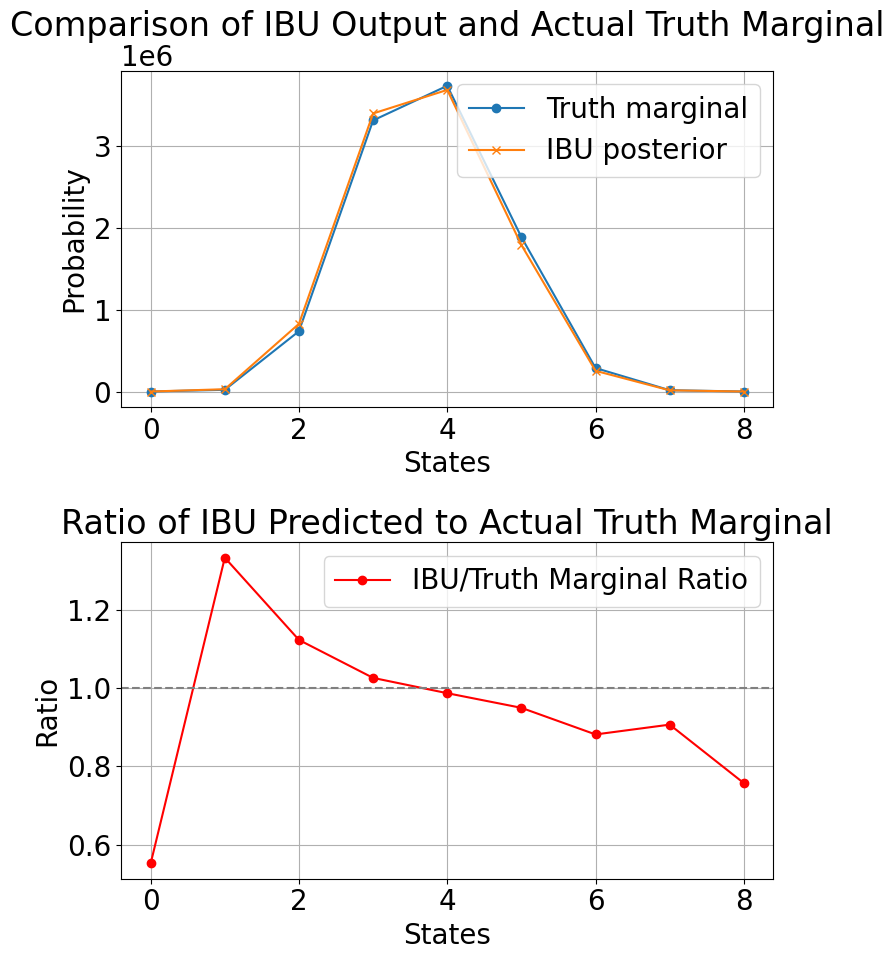

In [37]:
plt.figure(figsize=(8, 10))

# Top panel: Actual vs. Predicted
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first plot
plt.plot(truth_marginal, label='Truth marginal', marker='o')
plt.plot(ibu, label='IBU posterior', marker='x')
plt.title('Comparison of IBU Output and Actual Truth Marginal')
plt.xlabel('States')
plt.ylabel('Probability')
plt.legend()
plt.grid(True)

# Bottom panel: Ratio of IBU to Actual
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second plot
ratio = ibu / truth_marginal
plt.plot(ratio, label='IBU/Truth Marginal Ratio', marker='o', color='red')
plt.title('Ratio of IBU Predicted to Actual Truth Marginal')
plt.xlabel('States')
plt.ylabel('Ratio')
plt.axhline(y=1, color='gray', linestyle='--')  # Add a horizontal line at y=1 for reference
plt.legend()
plt.grid(True)

plt.tight_layout()  # Adjusts subplot params so that subplots are nicely fit in the figure area.
plt.show()

# Fit IBU to gaussian

In [38]:
bin_widths = np.diff(bins)
total_area = np.sum(ibu * bin_widths)
ibu_normalized = ibu / total_area

bins_midpoints = 0.5 * (bins[:-1] + bins[1:])

gaussian = norm.pdf

# Fit Gaussian
params, _ = curve_fit(gaussian, bins_midpoints, ibu_normalized, p0=[0, 1])

mu_ibu, sig_ibu = params
print(f"{mu_true = }")
print(f"{sig_true = }")
print(f"{mu_ibu = }")
print(f"{sig_ibu = }")

mu_true = 0
sig_true = 1
mu_ibu = -0.15094875145544906
sig_ibu = 1.1248123618053754


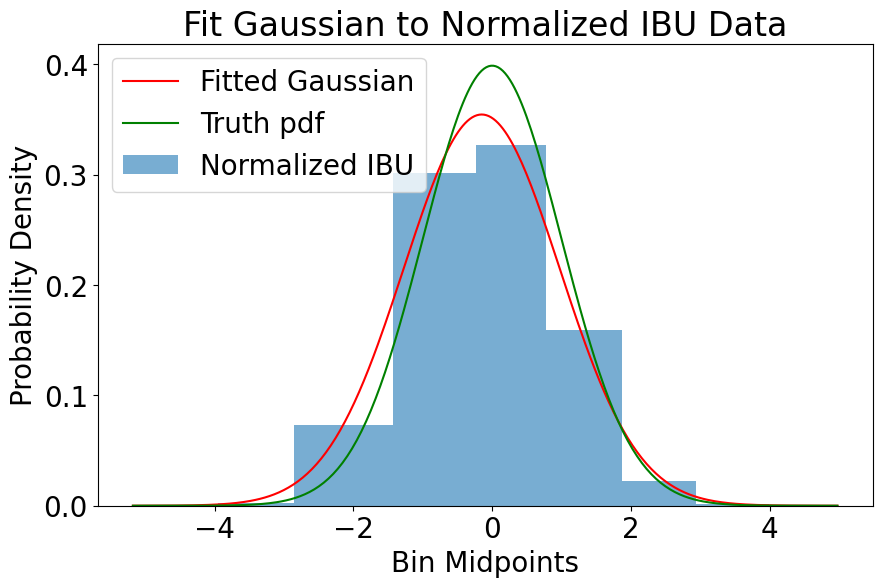

In [39]:
x_values = np.linspace(bins[0], bins[-1], 300)
gaussian_curve = gaussian(x_values, mu_ibu, sig_ibu)
truth_pdf = gaussian(x_values, mu_true, sig_true)

plt.figure(figsize=(10, 6))
plt.bar(bins_midpoints, ibu_normalized, width=bin_widths, alpha=0.6, label='Normalized IBU')
plt.plot(x_values, gaussian_curve, 'r-', label='Fitted Gaussian')
plt.plot(x_values, truth_pdf, 'g-', label='Truth pdf')
plt.title('Fit Gaussian to Normalized IBU Data')
plt.xlabel('Bin Midpoints')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

In [40]:
mu_values = np.linspace(min(bins_midpoints), max(bins_midpoints), 10)
sigma_values = np.linspace(0.1, max(bin_widths)*2, 10)

results = []

for mu in mu_values:
    for sigma in sigma_values:
        expected = gaussian(bins_midpoints, mu, sigma)
        expected_normalized = expected / np.sum(expected) * np.sum(ibu_normalized)
        chi2, p_value = chisquare(f_obs=ibu_normalized, f_exp=expected_normalized)
        results.append((mu, sigma, chi2 if chi2 < 10 else np.inf))

print("{:<10} {:<10} {:<10}".format("Mu", "Sigma", "Chi-Squared"))
for res in results:
    if any(np.isinf(res)):
        continue
    print("{:<10.2f} {:<10.2f} {:<10.2f}".format(res[0], res[1], res[2]))

Mu         Sigma      Chi-Squared
-4.57      2.24       6.62      
-4.57      2.54       3.80      
-4.57      2.85       2.64      
-3.56      1.93       5.24      
-3.56      2.24       2.94      
-3.56      2.54       2.07      
-3.56      2.85       1.66      
-2.56      1.63       3.18      
-2.56      1.93       1.83      
-2.56      2.24       1.37      
-2.56      2.54       1.18      
-2.56      2.85       1.09      
-1.55      1.02       6.94      
-1.55      1.32       1.26      
-1.55      1.63       0.76      
-1.55      1.93       0.67      
-1.55      2.24       0.69      
-1.55      2.54       0.74      
-1.55      2.85       0.79      
-0.54      1.02       0.19      
-0.54      1.32       0.10      
-0.54      1.63       0.20      
-0.54      1.93       0.32      
-0.54      2.24       0.45      
-0.54      2.54       0.57      
-0.54      2.85       0.68      
0.46       1.02       0.45      
0.46       1.32       0.21      
0.46       1.63       0.27      
0.46     

/global/home/users/krishdesai/anaconda3/envs/python3122/lib/python3.12/site-packages/scipy/stats/_stats_py.py:8022: RuntimeWarning: overflow encountered in divide
  terms = (f_obs_float - f_exp)**2 / f_exp


In [41]:
min_chi2 = min(results, key=lambda x: x[2])
print("\nMinimum Chi-Squared:")
print("{:<10} {:<10} {:<10}".format("Mu", "Sigma", "Chi-Squared"))
print("{:<10.2f} {:<10.2f} {:<10.2f}".format(min_chi2[0], min_chi2[1], min_chi2[2]))


Minimum Chi-Squared:
Mu         Sigma      Chi-Squared
-0.54      1.32       0.10      
